# US Demographics Data

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import ipyleaflet as ipyl
import geopandas as gpd
import matplotlib
import ipywidgets as widgets
from ipywidgets import HTML
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import Polygon
from matplotlib.colors import LogNorm
from shapely.geometry import mapping, MultiPolygon, Polygon
from branca.colormap import linear, LinearColormap
import folium
from folium import plugins
from io import BytesIO
import binascii

## Load Demographics Data

Taken from the National Bureau of Economic Research Census data: 

https://data.nber.org/census/popest/countypopmonthasrh.csv

In [2]:
data = pd.read_csv('countypopmonthasrh.csv')
data = data[data.yearref > 2]

## Load County Shapes

Taken from the 2017 census TIGER files:

https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip

In [3]:
county_shapes = gpd.read_file('tl_2017_us_county').dropna(subset=['GEOID'])
county_shapes.GEOID = county_shapes.GEOID.astype(np.int64)
county_shapes.geometry = county_shapes.geometry.simplify(.02)

In [4]:
data = gpd.GeoDataFrame(data.merge(county_shapes[['GEOID', 'geometry']], left_on='county', right_on='GEOID'))
data.crs = county_shapes.crs

## Data Preprocessing

In [5]:
data_agg = data[data.agegrp == 0].copy()
data = data[data.agegrp > 0]

In [6]:
age_groups= {1: '0+',
 2: 5,
 3: 10,
 4: 15,
 5: 20,
 6: 25,
 7: 30,
 8: 35,
 9: 40,
 10: 45,
 11: 50,
 12: 55,
 13: 60,
 14: 65,
 15: 70,
 16: 75,
 17: 80,
 18: 85}

In [7]:
data.agegrp = data.agegrp.replace(age_groups)

## Preparing Data for 2016

In [8]:
data_2016 = data[data.year == 2016].copy()
data_2016_agg = data_agg[data_agg.year == 2016].copy()
data_2016_agg['female_percentage'] = np.round(data_2016_agg.tot_female / data_2016_agg.tot_pop * 100, 2)

## Plotting Function

In [9]:
def bbox_to_polyon(min_x, min_y, max_x, max_y):
    return Polygon([(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)])

def plot_geo_df(geo_df, value_col, cmap='RdBu', vmin=0, vmax=1, ax=None, cax=None, legend=False,
               plot_kwargs = {}):
    if ax is None:
        fig, ax = plt.subplots()
        
    if legend and cax is None:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)

    geo_df.plot(value_col, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax, legend=legend, cax=cax, **plot_kwargs)
    geo_df.boundary.plot(ax=ax, color='black', linewidth=.25, alpha = .25)
    ax.axis('off')

In [10]:
def plot_us_data(geo_df, column, title, center=50, cmap='RdBu_r', logarithmic = False):
    fig, ax1 = plt.subplots(1, figsize=(20,20), dpi=200)
    fig.patch.set_facecolor('#f5f5f5'), fig.patch.set_alpha(1)
    ax1.set_title(title)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="1.5%", pad=0.1)
    ax2 = inset_axes(ax1, width="30%", height="30%", loc=3)

    alaska = geo_df[geo_df.geometry.within(bbox_to_polyon(-179, 50, -125, 72))]
    continental_us = geo_df[geo_df.geometry.within(bbox_to_polyon(-126, 23, -66,  50))]

    if center is None:
        vmin, vmax = geo_df[column].min(), geo_df[column].max()
    else:
        rng = np.max(np.abs(geo_df[column] - center))
        vmin, vmax = center-rng, center+rng
    
    plot_kwargs = dict(norm=LogNorm(vmin=vmin, vmax=vmax)) if logarithmic else {}
    plot_geo_df(continental_us, column, ax=ax1, legend=True, cax=cax, vmin=vmin, vmax=vmax, cmap=cmap,
               plot_kwargs=plot_kwargs)
    plot_geo_df(alaska, column, ax=ax2, vmin=vmin, vmax=vmax, cmap=cmap,
               plot_kwargs=plot_kwargs)

## Percentage of female population

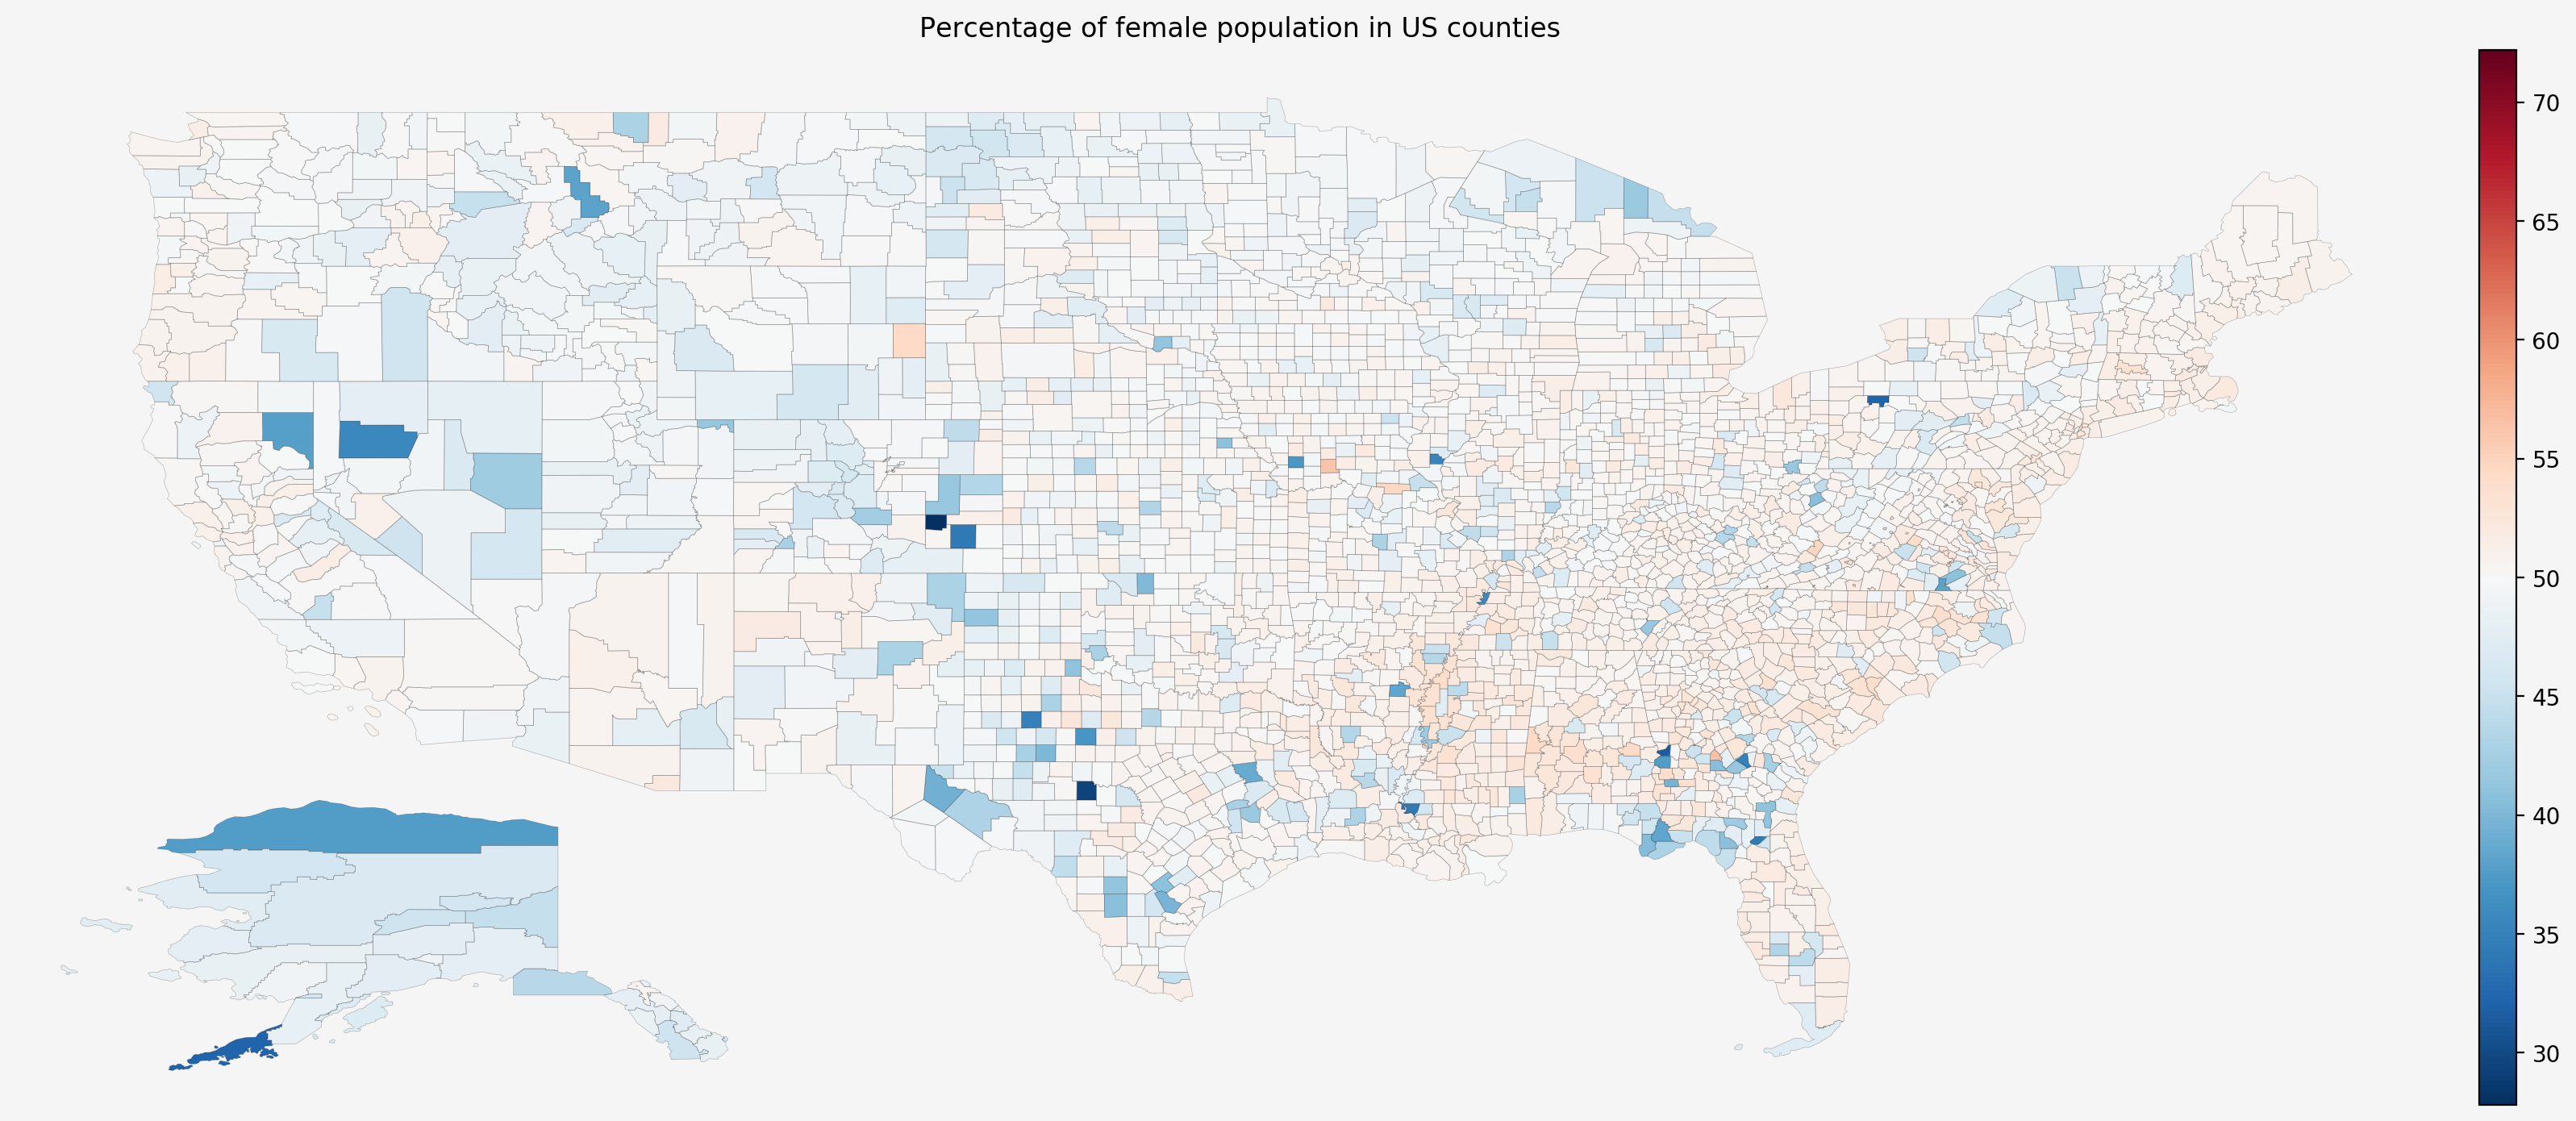

In [11]:
plot_us_data(data_2016_agg, 'female_percentage', 'Percentage of female population in US counties')

## Population

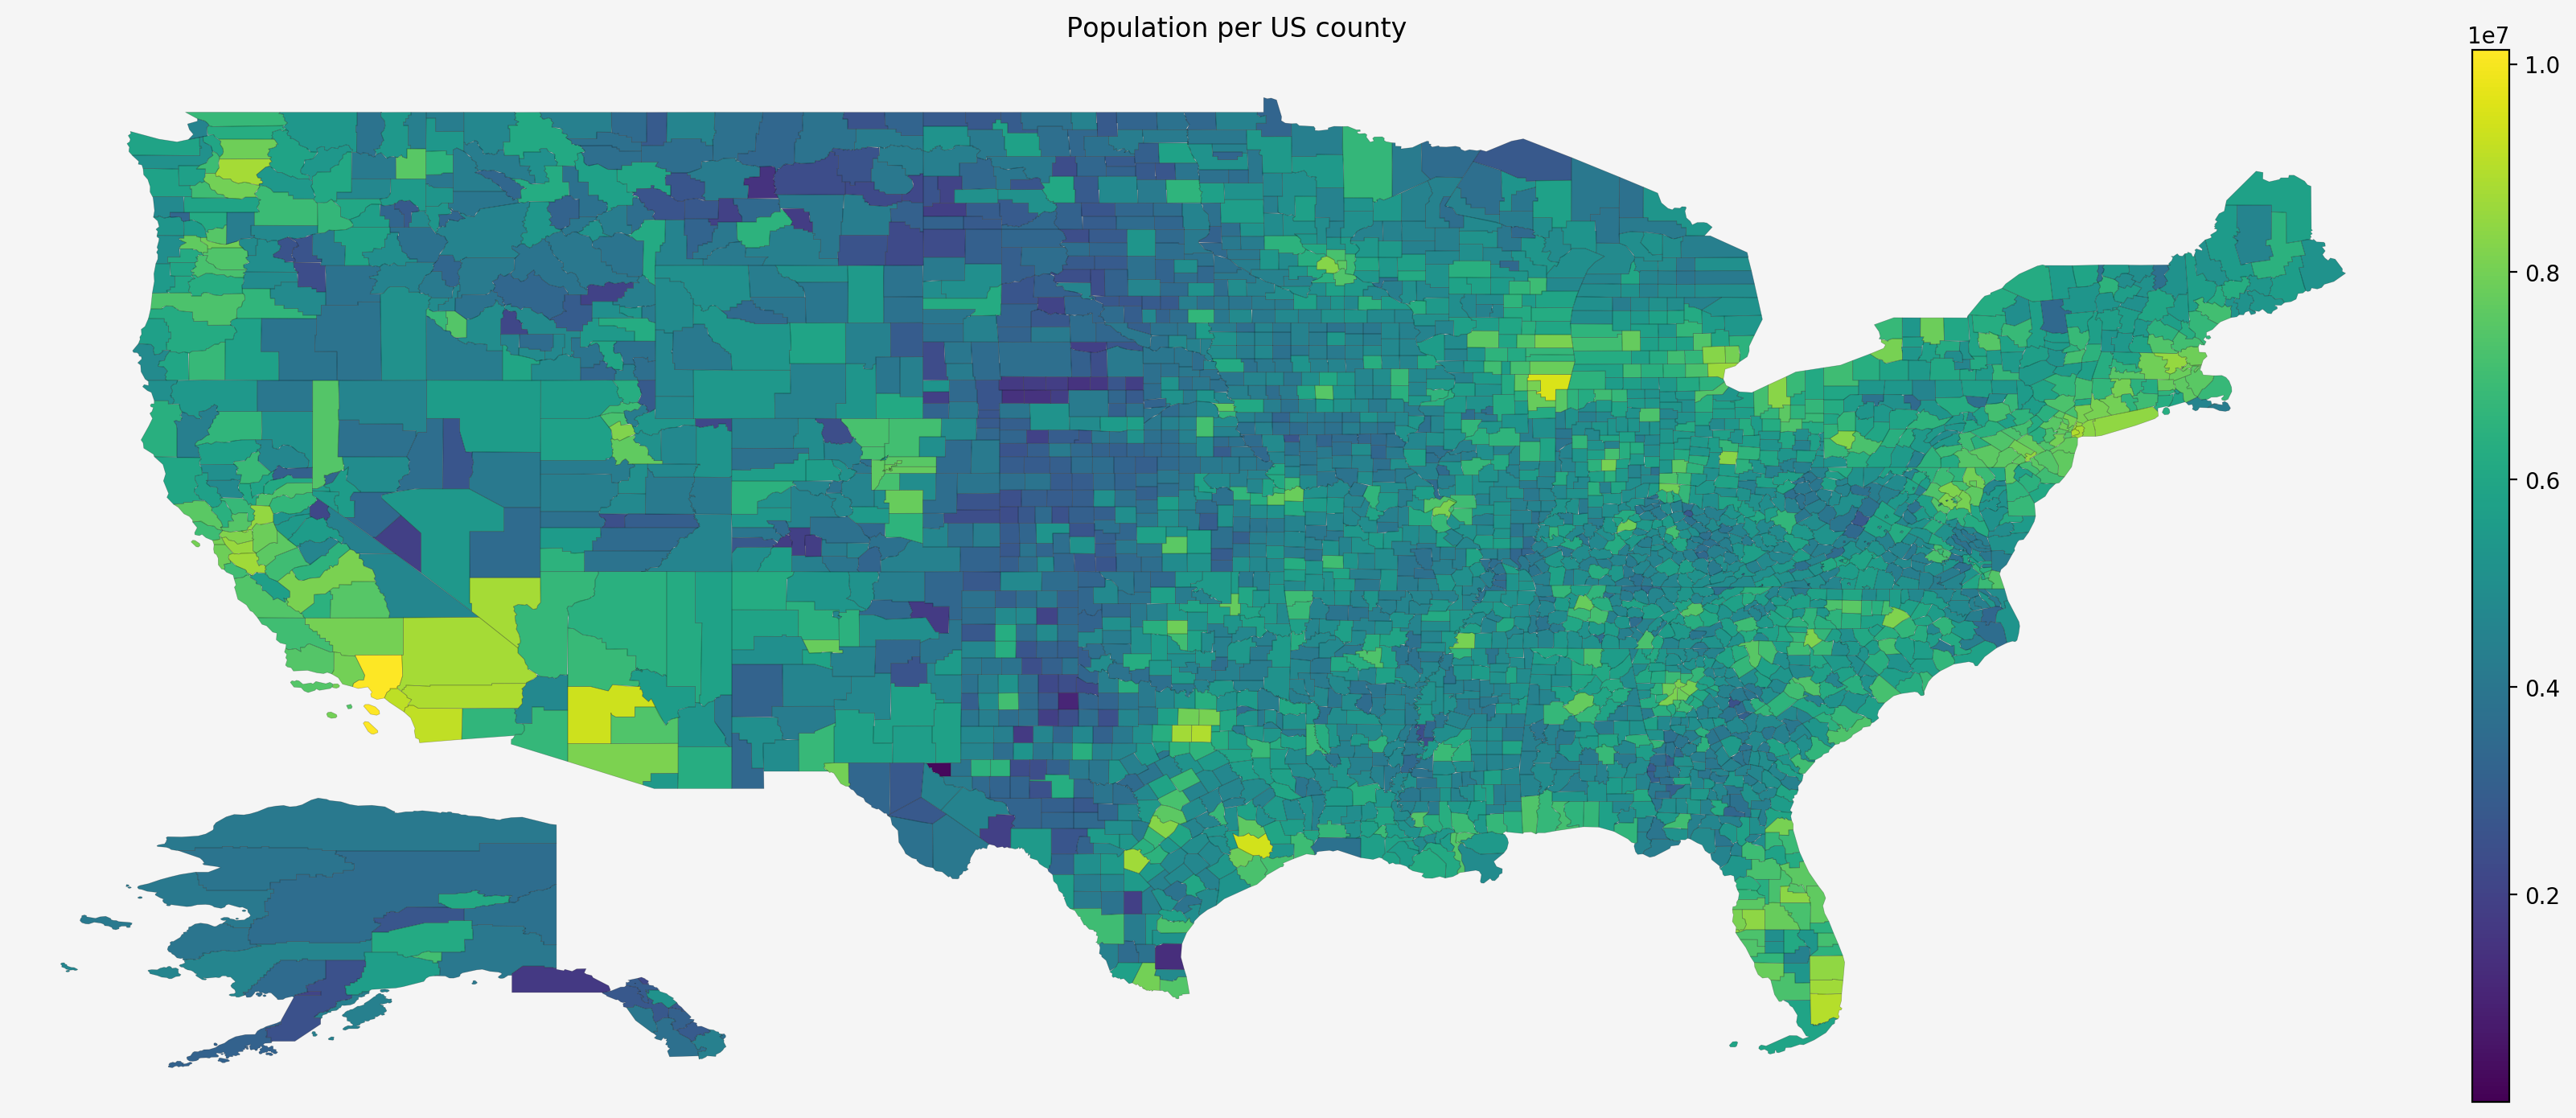

In [12]:
plot_us_data(data_2016_agg, 'tot_pop', 'Population per US county', cmap='viridis', center=None, logarithmic=True)

## Interactive

### County Demographic and Time plot

In [13]:
def get_heatmap_plot(df, vmin=0, vmax=1, cmap='viridis', choro_col='female_percentage',
                    x_col='year', y_col='agegrp'):
    def plot_county(df:pd.DataFrame):
        heatmap_data = df.pivot(columns=x_col, index=y_col, values=choro_col)
        sns.heatmap(heatmap_data, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)

    def encode_plot(fig: plt.Figure):
        with BytesIO() as buf:
            fig.canvas.print_png(buf)
            img_data = binascii.b2a_base64(buf.getvalue()).decode()
        img_html = '<img src="data:image/png;base64,{}">'.format(img_data)
        return img_html
    
    fig, ax = plt.subplots(figsize=(3,2))
    plot_county(df)
    img_data = encode_plot(fig)
    plt.close(fig)
    return img_data

In [14]:
def get_choropleth_layer(geo_df: gpd.GeoDataFrame, choro_col: str, name_col: str, 
                         colormap, name: str = '', vmin=0, vmax=1, id_col: str='county'):

    def create_geo_data(df: gpd.GeoDataFrame, name_col: str):
        return ipyl.GeoData(geo_dataframe=df).data
    
    def get_style(feature):
        return {'fillColor': colormap(feature['properties'][choro_col]), 'color': 'grey', 'weight': .1, 
                'lineOpacity': .4, 'fillOpacity': .8}
    
    def get_hover_style(feature):
        return {'fillColor': colormap(feature['properties'][choro_col]), 
                'lineOpacity': 1, 'fillOpacity': 1}

    geo_json_data = create_geo_data(geo_df, name_col = name_col)
    tooltip=folium.features.GeoJsonTooltip(fields=[name_col, choro_col, 'img'],
            aliases=[name_col.replace('_', ' '), choro_col.replace('_', ' '), ''])
    quantiles = np.quantile(geo_df[choro_col], (0, 0.01, .1, .25, .5, .75, .9, .99, 1))
    
    layer = folium.GeoJson(ipyl.GeoData(geo_dataframe=geo_df).data, highlight_function=get_hover_style,
        name=name, smooth_factor=0, tooltip=tooltip, style_function=get_style
    )


    return layer

def plot_us_data_map(df, choro_column = 'female_percentage', layers_column = 'year', m=None,
                    vmin = 0, vmax=1, layer_val = 2016):
    if m is None:
        m = folium.Map(location=[48, -102], zoom_start=3)
        
    colormap = LinearColormap(colors=['darkblue', 'white', 'darkred'], index=[vmin, (vmax+vmin)/2, vmax],
                              vmin=vmin,vmax=vmax)
        
    
    df['female_percentage'] = df.tot_female / df.tot_pop * 100
    plots = {}
    for county in df.county.unique():
        indexer = df.county == county
        county_df = df[indexer]
        img = get_heatmap_plot(county_df, vmin=vmin, vmax=vmax, cmap='RdBu_r', choro_col = choro_column,
                              x_col='year', y_col='agegrp')
        plots[county] = img

    layer_df = df[df[layers_column] == layer_val]
    grouped = layer_df.groupby('county')
    layer_df_agg = gpd.GeoDataFrame(grouped.sum())
    layer_df_agg['ctyname'] = grouped.ctyname.first()
    layer_df_agg['geometry'] = grouped.geometry.first()

    layer_df_agg['female_percentage'] = np.round(layer_df_agg.tot_female / layer_df_agg.tot_pop * 100, 2)

    layer_df_agg.crs = df.crs
    layer_df_agg.reset_index(inplace=True)
    layer_df_agg['img'] = layer_df_agg.county.apply(lambda c: plots[c])

    layer = get_choropleth_layer(layer_df_agg, choro_col=choro_column, name_col = 'ctyname',
                                name = '{} {}'.format(layers_column, layer_val).replace('_', ' '),
                                colormap=colormap, vmin=vmin, vmax=vmax)
    layer.add_to(m)
        
    m.add_child(colormap)
    folium.LayerControl().add_to(m)
    plugins.Fullscreen().add_to(m)
    
    return m

In [15]:
values = data_2016_agg.tot_female / data_2016_agg.tot_pop * 100
vmin, vmax = values.agg([np.min, np.max]).values
rng = np.max(np.abs(values-50))

m_2016 = plot_us_data_map(data, vmin=50-rng, vmax=50+rng)

In [16]:
m_2016.save('gender_balance_2016.html')